<a href="https://colab.research.google.com/github/ach224/Prediction_eligibilite_pret_bancaire/blob/main/Projet_1_%E2%80%93_Pr%C3%A9diction_de_l%E2%80%99%C3%A9ligibilit%C3%A9_%C3%A0_un_pr%C3%AAt_bancaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Pour avoir la dataset automatiquement avec Kaggle API

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aicha224","key":"73c1e040f8d55a169c99b1f93cf1d529"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ninzaami/loan-predication

Dataset URL: https://www.kaggle.com/datasets/ninzaami/loan-predication
License(s): CC0-1.0
  0% 0.00/7.83k [00:00<?, ?B/s]
100% 7.83k/7.83k [00:00<00:00, 31.7MB/s]


In [4]:
!unzip loan-predication.zip

Archive:  loan-predication.zip
  inflating: train_u6lujuX_CVtuZ9i (1).csv  


In [5]:
!mv "train_u6lujuX_CVtuZ9i (1).csv" train.csv

# Projet Prédiction Éligibilité Prêt
Objectif : prédire si un client est éligible à un prêt bancaire.


# 1 - Import des librairies

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2 - Chargement du dataset

In [28]:
# Charger les données
df = pd.read_csv("train.csv")


| Nom de la colonne   | Signification en français                          |
| ------------------- | -------------------------------------------------- |
| `Loan_ID`           | Identifiant du prêt                                |
| `Gender`            | Sexe du demandeur (Male/Female)                    |
| `Married`           | Marié(e) ou non (Yes/No)                           |
| `Dependents`        | Nombre de personnes à charge                       |
| `Education`         | Niveau d’éducation (Graduate/Not Graduate)         |
| `Self_Employed`     | Travailleur indépendant (Yes/No)                   |
| `ApplicantIncome`   | Revenu du demandeur principal                      |
| `CoapplicantIncome` | Revenu du co-demandeur (s’il y a un co-emprunteur) |
| `LoanAmount`        | Montant du prêt demandé (en milliers)              |
| `Loan_Amount_Term`  | Durée du prêt (en mois)                            |
| `Credit_History`    | Historique de crédit (1 = bon, 0 = mauvais)        |
| `Property_Area`     | Zone de résidence (Urban / Semiurban / Rural)      |
| `Loan_Status`       | Statut du prêt (Y = accordé / N = refusé)          |


In [29]:
# Voir en-têtes
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# 3 - Exploration initiale

In [30]:
# Informations générales
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [31]:
# Valeurs manquantes
df.isna().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


In [32]:
# Vérifier doublons
df.duplicated().sum()

np.int64(0)

### Remarque sur le dataset

- Le dataset contient **614 clients** et **13 colonnes(variables)**.  

- Certaines colonnes importantes présentent des **valeurs manquantes**, notamment :
  - `Gender` (13 valeurs manquantes)  
  - `Married` (3 valeurs manquantes)  
  - `Dependents` (15 valeurs manquantes)  
  - `Self_Employed` (32 valeurs manquantes)  
  - `LoanAmount` (22 valeurs manquantes)  
  - `Loan_Amount_Term` (14 valeurs manquantes)  
  - `Credit_History` (50 valeurs manquantes)  

> Ces valeurs manquantes devront être traitées avant la modélisation pour éviter les erreurs et pour que le modèle apprenne correctement.  

- le total des doublons est 0, donc il n’y a pas de doublons dans le dataset.

- La colonne `Loan_ID` est un identifiant unique et **ne sera pas utilisée** pour la prédiction, car il ne contient aucune information sur le client ou son éligibilité, il n’apporte rien au modèle.

- Les variables catégorielles (`Gender`, `Married`, `Education`, `Self_Employed`, `Property_Area`) devront être **encodées** pour être utilisées car les modèles de machine learning (Logistic Regression, Random Forest, Gradient Boosting…) ne comprennent que des nombres, donc il faut transformer ces textes en nombres.  

- La variable cible `Loan_Status` est complète, mais il faudra vérifier **l'équilibre des classes** (Y/N) pour savoir si un traitement du déséquilibre est nécessaire.

*Pourquoi vérifier l’équilibre des classes ?*

- Si le nombre de prêts accordés (Y) est beaucoup plus élevé que le nombre de refus (N), le dataset est déséquilibré.

    Exemple : 90% de Y (Oui) et 10% de N (Non) → le modèle pourrait juste prédire Y tout le temps et avoir une fausse impression de performance.


#4 - Traitement des valeurs manquantes


In [33]:
# Colonnes numériques : remplacer par la médiane
for col in ['LoanAmount', 'Loan_Amount_Term']:
    df[col] = df[col].fillna(df[col].median())

In [34]:
# Colonnes categorielle : remplacer par le mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    df[col] = df[col].fillna(df[col].mode()[0])


La méthode .fillna() en pandas sert à remplir les valeurs manquantes (NaN) dans un DataFrame ou une colonne.

In [35]:
#test
df.isna().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [36]:
# Suppression de la colonne Loan_ID
df.drop('Loan_ID', axis=1, inplace=True)

# Vérification
df.head()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Traitement des valeurs manquantes

- **Colonnes numériques** : `LoanAmount`, `Loan_Amount_Term`  
  - Nous avons choisi de **remplir les valeurs manquantes avec la médiane** de chaque colonne.  
  - **Justification** : la médiane est moins sensible aux valeurs extrêmes (outliers) que la moyenne et représente mieux le “client typique”. Par exemple, un prêt très élevé n’influencera pas la valeur utilisée pour remplir les manquants.  

- **Colonnes catégorielles** : `Gender`, `Married`, `Dependents`, `Self_Employed`, `Credit_History`  
  - Nous avons choisi de **remplir les valeurs manquantes avec la valeur la plus fréquente (mode)** de chaque colonne.  
  - **Justification** : cela permet de conserver la distribution originale des catégories et de remplir les données manquantes avec la valeur la plus probable pour ces clients, sans introduire de bruit artificiel.  

- **Colonnes très peu utiles ou identifiants** : `Loan_ID`  
  - Cette colonne ne contient aucune information sur l’éligibilité du prêt.  
  - Elle sera **supprimée** car elle n’apporte rien au modèle et pourrait biaiser la prédiction.  

> Ces choix sont des pratiques standards pour un **nettoyage initial des données** avant l’encodage et la modélisation. Ils permettent de préparer le dataset pour que les modèles de machine learning puissent apprendre correctement.


# 5 - Encodage des variables categorielles et cible

In [37]:
# Colonnes catégorielles à encoder
cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

# One-Hot Encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Vérification
df.head()


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0.0,128.0,360.0,1.0,Y,True,False,False,False,False,True
1,1,4583,1508.0,128.0,360.0,1.0,N,True,True,False,False,False,False
2,0,3000,0.0,66.0,360.0,1.0,Y,True,True,False,True,False,True
3,0,2583,2358.0,120.0,360.0,1.0,Y,True,True,True,False,False,True
4,0,6000,0.0,141.0,360.0,1.0,Y,True,False,False,False,False,True


In [38]:
# Convertir la variable df['Dependents'] en int
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)
df['CoapplicantIncome'] = df['CoapplicantIncome'].astype(int)
df['LoanAmount'] = df['LoanAmount'].astype(int)
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(int)
df['Credit_History'] = df['Credit_History'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Dependents               614 non-null    int64 
 1   ApplicantIncome          614 non-null    int64 
 2   CoapplicantIncome        614 non-null    int64 
 3   LoanAmount               614 non-null    int64 
 4   Loan_Amount_Term         614 non-null    int64 
 5   Credit_History           614 non-null    int64 
 6   Loan_Status              614 non-null    object
 7   Gender_Male              614 non-null    bool  
 8   Married_Yes              614 non-null    bool  
 9   Education_Not Graduate   614 non-null    bool  
 10  Self_Employed_Yes        614 non-null    bool  
 11  Property_Area_Semiurban  614 non-null    bool  
 12  Property_Area_Urban      614 non-null    bool  
dtypes: bool(6), int64(6), object(1)
memory usage: 37.3+ KB


In [39]:
# Encoder Loan_Status
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Vérification
df['Loan_Status'].value_counts()

,count
Loan_Status,
1,422
0,192


In [40]:
df.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0,5849,0,128,360,1,1,True,False,False,False,False,True
1,1,4583,1508,128,360,1,0,True,True,False,False,False,False
2,0,3000,0,66,360,1,1,True,True,False,True,False,True
3,0,2583,2358,120,360,1,1,True,True,True,False,False,True
4,0,6000,0,141,360,1,1,True,False,False,False,False,True


## - Encodage des variables catégorielles

Les modèles de machine learning ne comprennent que des valeurs
numériques.

Nous avons donc transformé les colonnes catégorielles en nombres :
Gender, Married, Education, Self_Employed, Property_Area ont été encodées à l’aide de variables booléennes (True/False) grâce à pd.get_dummies().

Exemple : Property_Area (Urban, Semiurban, Rural) est devenue trois colonnes :
Property_Area_Urban, Property_Area_Semiurban, Property_Area_Rural.

Justification :

L’encodage **One-Hot** permet de conserver la signification de chaque catégorie sans introduire d’ordre artificiel.

Cela rend les variables directement utilisables par les modèles comme la régression logistique ou les arbres de décision.


## - Encodage de la variable cible Loan_Status

La variable cible Loan_Status a été encodée avec :
* Y → 1 (prêt accordé)
* N → 0 (prêt refusé)

Justification :

Cet encodage numérique est nécessaire pour la modélisation supervisée.

Le résultat permettra au modèle de prédire une probabilité comprise entre 0 et 1, correspondant au risque d’acceptation du prêt.


## - Vérification de l’équilibre des classes

Après encodage, la distribution de Loan_Status est la suivante :

* 68,7 % de prêts accordés (1)

* 31,3 % de prêts refusés (0)

Remarque : il existe donc un léger déséquilibre entre les classes.
Nous le prendrons en compte lors de la phase de modélisation (par exemple via class_weight ou la technique SMOTE).

# 6 - Normalisation / Standardisation des variables numériques

Pour le moment, aucune normalisation ou standardisation n’a été appliquée.
Cette étape dépend du type de modèle de machine learning choisi :

🔹 Nécessaire pour les modèles sensibles à l’échelle des données (Régression logistique, SVM, KNN, Réseaux de neurones).

🔹 Optionnelle pour les modèles basés sur les arbres (Arbre de décision, Random Forest, XGBoost), qui ne dépendent pas de l’échelle des variables.

Une normalisation (ou standardisation) pourra donc être réalisée plus tard, une fois le modèle de prédiction sélectionné.

# 7 - Visualiser la distribution des variables

/tmp/ipython-input-2300768997.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=var_a_visualiser, data=df, palette="Set2", hue = None, legend = False)
/tmp/ipython-input-2300768997.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=var_a_visualiser, data=df, palette="Set2", hue = None, legend = False)
/tmp/ipython-input-2300768997.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=var_a_visualiser, data=df, palette="Set2", hue = None, legend = False)
/tmp/ipython-input-2300768997.py:12: FutureWarning: 

Passing `palette` w

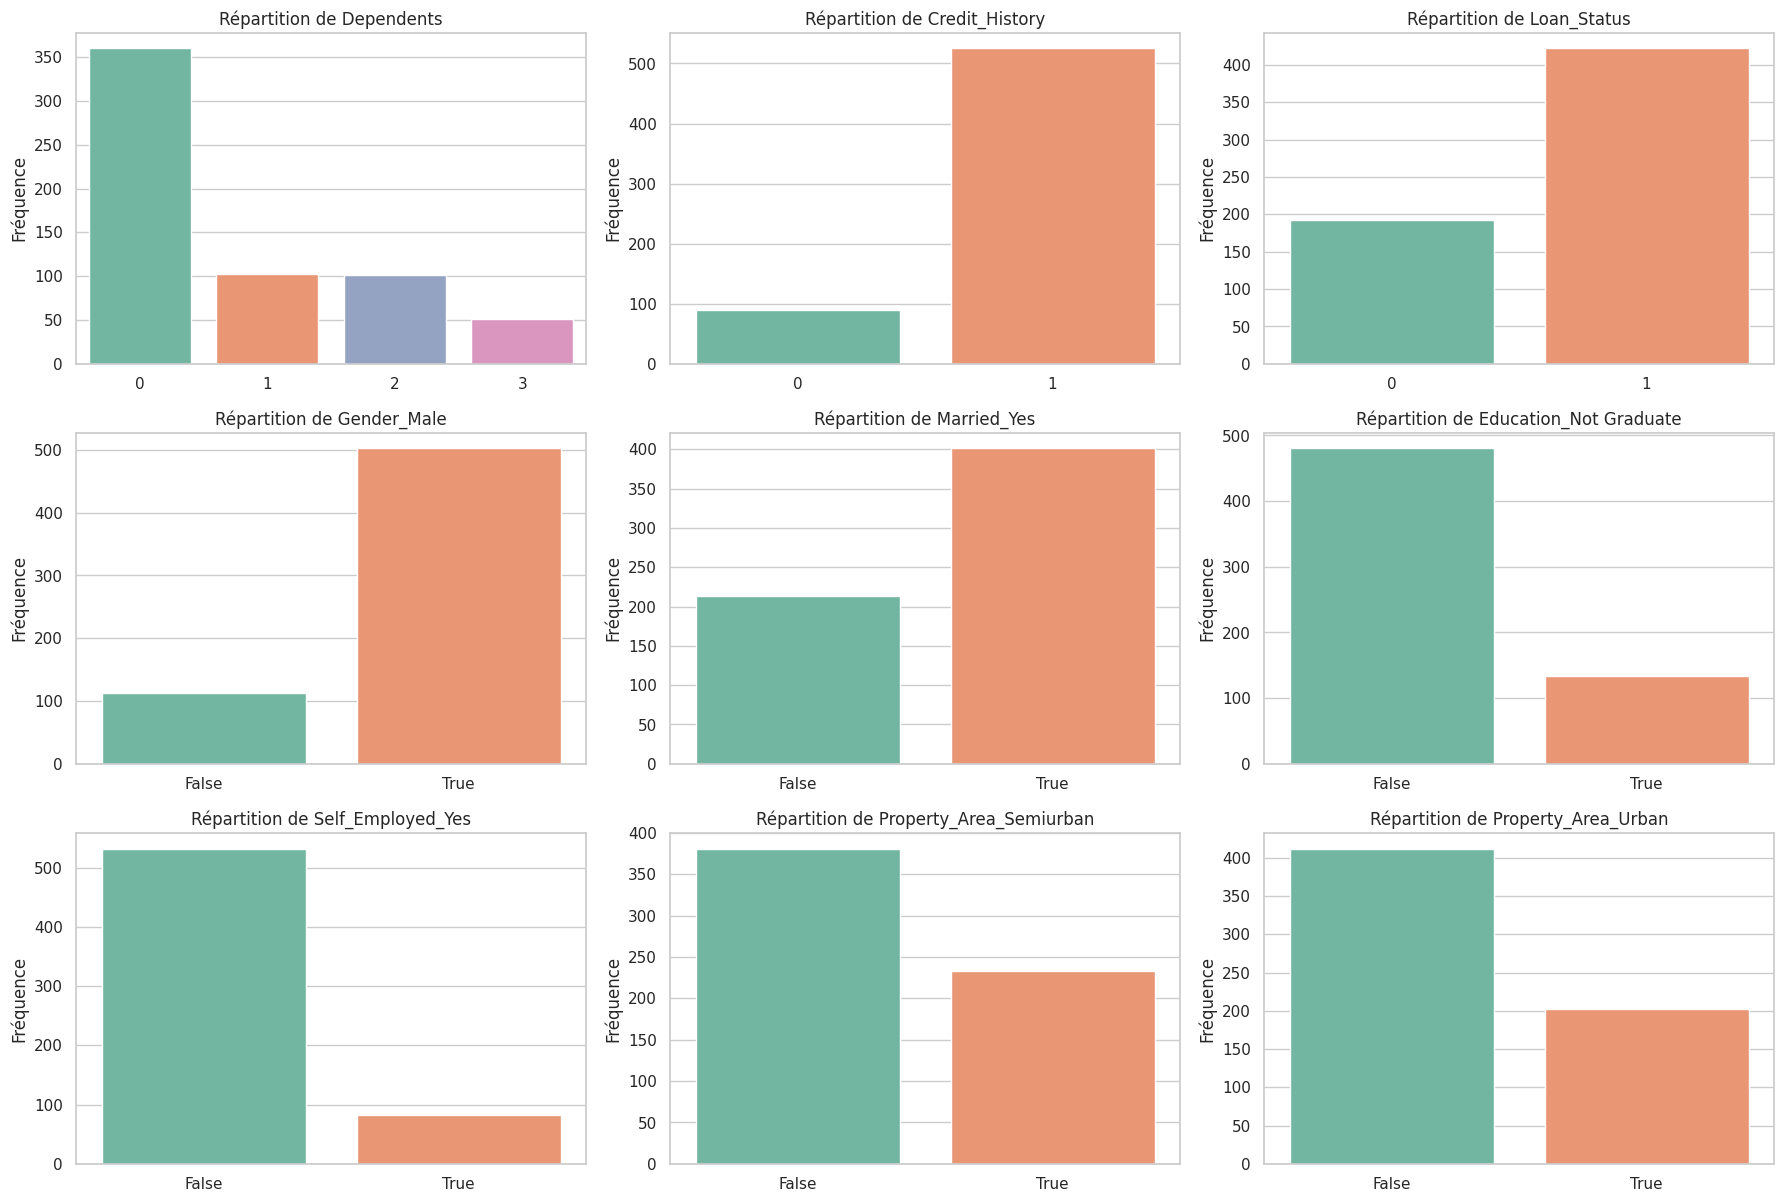

In [45]:
# Visualisation de la distribution des variables
var_a_visualiser = df.drop(columns = ["ApplicantIncome", "CoapplicantIncome", "Loan_Amount_Term", "LoanAmount"])

# Mosaïque de graphiques
sns.set(style="whitegrid", palette = "pastel")
# Nbr_graph_par_ligne = 3
n_cols = 3
n_rows = int(np.ceil(len(var_a_visualiser) / n_cols))
plt.figure(figsize=(18, n_rows * 4))
for i, var_a_visualiser in enumerate(var_a_visualiser, 1):
  plt.subplot(n_rows, n_cols, i)
  sns.countplot(x=var_a_visualiser, data=df, palette="Set2", hue = None, legend = False)
  plt.title(f"Répartition de {var_a_visualiser}")
  plt.xlabel("")
  plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

L'analyse de la distributions des variables nous permet d'établir les constatations suivantes :  
* L'écrasante majorité des candidats n'ont pas de personnes à charge (dependents).    
* Plus de 80% ont déjà eu un crédit auparavant (credit_history).
* La plupart des prêts ont été approuvés (Loan_Status).
* Il y a presque 5 fois plus d'hommes que de femmes (Gender_Male).
* Il y a quasiment 2 fois plus de demandeurs de prêts mariés que le contraire (Married_Yes).
* La plupart des potentiels prêteurs ont un niveau d’éducation élevé (Education_Not Graduate).
* Moins d'une personne sur 5 est auto-entrepreneur (Self_Employed_Yes).
* La répartition géographique des biens est relativement équilibrée, avec un léger avantage pour les zones semi-urbaines.

Ces premières observations offrent une vue d’ensemble du profil type des emprunteurs dans l’échantillon, avant toute analyse de relation entre variables.

Désormais, on va observer les variables numériques.

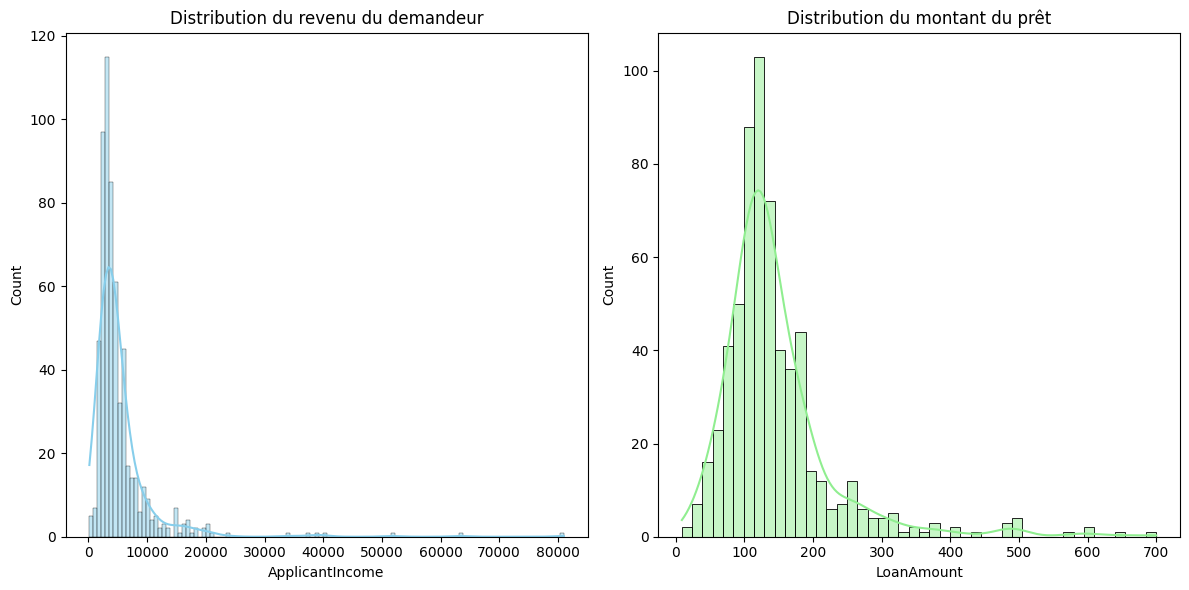

In [21]:
# Configuration des graphiques
plt.figure(figsize=(12,6))

# Distribution du revenu principal
plt.subplot(1, 2, 1)
sns.histplot(df['ApplicantIncome'], kde=True, color='skyblue')
plt.title('Distribution du revenu du demandeur')

# Distribution du montant du prêt
plt.subplot(1, 2, 2)
sns.histplot(df['LoanAmount'], kde=True, color='lightgreen')
plt.title('Distribution du montant du prêt')

plt.tight_layout()
plt.show()


À observer :

la distribution n'est pas symétrique, plus asymétrique vers la droite.

Avec des revenus ou montants très élevés (valeurs aberrantes).

# Rendre la distribution plus symétrique et diminuer l'impact des valeurs aberrantes




In [22]:
# Pour les revenus
df['ApplicantIncome_log'] = np.log1p(df['ApplicantIncome'])

# Pour le montant de prêt
df['LoanAmount_log'] = np.log1p(df['LoanAmount'])

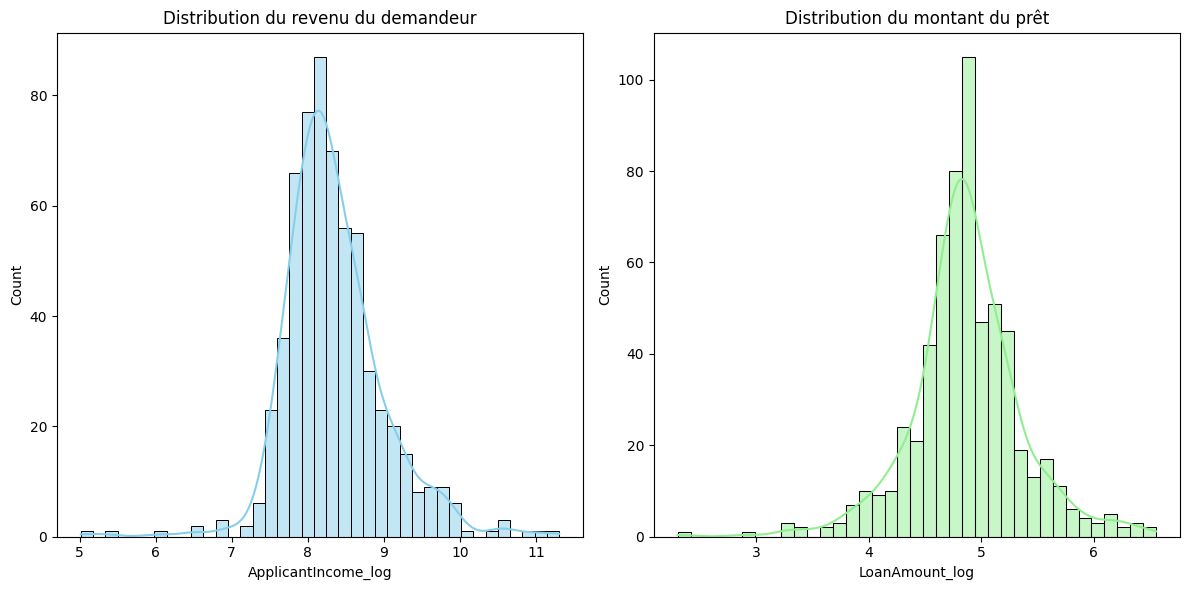

In [23]:
# Configuration des graphiques
plt.figure(figsize=(12,6))

# Distribution du revenu principal
plt.subplot(1, 2, 1)
sns.histplot(df['ApplicantIncome_log'], kde=True, color='skyblue')
plt.title('Distribution du revenu du demandeur')

# Distribution du montant du prêt
plt.subplot(1, 2, 2)
sns.histplot(df['LoanAmount_log'], kde=True, color='lightgreen')
plt.title('Distribution du montant du prêt')

plt.tight_layout()
plt.show()

Transformation logarithmique du revenu (ApplicantIncome)

Le revenu des demandeurs présente une forte asymétrie :
la majorité des clients ont un revenu faible à moyen, tandis qu’un petit nombre ont des revenus très élevés.

Ces valeurs extrêmes peuvent influencer les analyses et fausser certains modèles de machine learning.

Pour corriger cela, nous appliquons une transformation logarithmique.

🎯 Objectif

Rendre la distribution du revenu plus symétrique (plus proche d’une distribution normale).

Améliorer la lisibilité des visualisations (histogrammes, boxplots, etc.).

Faciliter la modélisation, notamment pour les algorithmes sensibles à la variance comme la régression linéaire ou logistique.

## Comparer les revenus entre éligibles et non éligibles
Objectif → voir si les revenus influencent la décision de prêt, en prenant en compte qu'il y a le revenu du demandeur seul et les revenus du demandeur + codemandeur.

/tmp/ipython-input-1563879925.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Loan_Status', y='ApplicantIncome_log', data=df, palette='pastel')


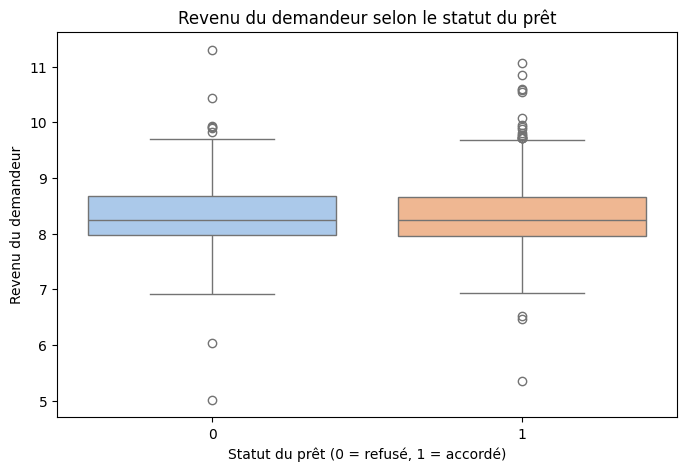

In [24]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Loan_Status', y='ApplicantIncome_log', data=df, palette='pastel')
plt.title("Revenu du demandeur selon le statut du prêt")
plt.xlabel("Statut du prêt (0 = refusé, 1 = accordé)")
plt.ylabel("Revenu du demandeur")
plt.show()


Médiane (ligne au milieu de la boîte) :

La médiane du revenu est presque la même pour les deux groupes → les personnes dont le prêt est accordé ou refusé gagnent en moyenne des revenus similaires.

Interprétation :

Le revenu n’est pas un critère suffisant pour prédire l’éligibilité au prêt.

Il pourrait toutefois interagir avec d’autres variables comme montant du prêt demandé, historique de crédit.